In [143]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta  

import os
import json
#import seaborn as sns

* Pattern 1 : les uids ayant trop d'activités par minutes
* Pattern 2 : les ips associées à trop de uids
* Pattern 3 : les uids qui enchainent les activités instantanément.

In [144]:
# Import file
filename = "../quickstart/data/logs_100_000.txt"
assert os.path.exists(filename)

cols = ['eventType', 'uid', 'timestamp', 'ip', 'impressionId']

# read file
def read_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    data = {col: [] for col in cols}
    for json_line in lines:
        dline = json.loads(json_line)
        for col in cols:
            data[col].append(dline[col])
    return data

data = read_file(filename)
df = pd.DataFrame(data)#.tail(50000)

# handle dates
df["timestamp"] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x).strftime("%Y-%m-%d %H-%M-%S"))
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H-%M-%S')

# Min max date
print(f"shape : {df.shape}")
min_time = df.timestamp.min()
max_time = df.timestamp.max()
num_mins = (max_time - min_time).total_seconds() / 60.0

print(f"Min timestamp : {min_time}")
print(f"Max timestamp : {max_time}")
print(f'Delta : {max_time - min_time}')

shape : (165141, 5)
Min timestamp : 2021-05-15 13:05:34
Max timestamp : 2021-05-15 15:32:02
Delta : 0 days 02:26:28


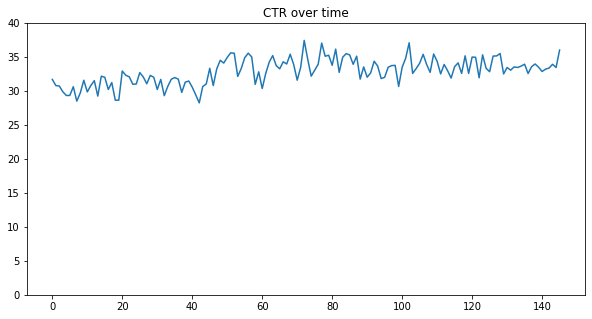

In [145]:
def CTR(df, returned=False, silent=False, meta=False):
    num_clicks = (df['eventType'] == 'click').sum()
    num_displays = (df['eventType'] == 'display').sum()
    ctr = round(100 * num_clicks / num_displays, 4)
    if not silent:
        print(f'CTR : {ctr}% | #clicks={num_clicks} ; #displays={num_displays}')
    if meta:
        return ctr, num_clicks, num_displays
    if returned:
        return ctr
    
    
def CTR_by_window(df, window_size, plot=True):
    delta = timedelta(minutes=window_size)
    start_time = df.timestamp.min()
    end_time = start_time + delta
    max_time = df.timestamp.max()
    ctrs, clicks, displays =  [], [], []
    while end_time < max_time:
        chunk_df = df[(df.timestamp < end_time) & (df.timestamp > start_time)]
        ctr, num_clicks, num_displays = CTR(chunk_df, returned=True, silent=True, meta=True)
        start_time += delta
        end_time += delta
        ctrs.append(ctr)
        clicks.append(num_clicks)
        displays.append(num_displays)
    if plot:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.plot(range(0, len(ctrs)*window_size, window_size), ctrs)
        ax.set_ylim(0, 40)
        ax.set_title('CTR over time');
    else:
        return ctrs, clicks, displays
    
CTR_by_window(df, 1)

In [146]:
df.uid.value_counts()
# 500 activité en 45 mins !!

8b61936f-39f6-4d99-8f51-1371c0eab8fb    1788
2d8ddda0-4ddd-42e8-a68d-175f8ac870b1    1777
71ab6a38-1bd1-4658-b5b4-ac5165959f32    1754
ac0eefba-ba4d-4057-ad84-052480ff4391    1754
1fe60aae-b716-4984-accf-edda1229d67d    1740
                                        ... 
95ac6223-d8de-43e5-a8a3-ad222f3030b9       1
61ab42a7-c614-4308-96c6-bb0fcbf70909       1
524c4561-4d94-4fa2-80fa-3bb0b450b543       1
36fadff8-8bda-4353-829e-4bc38410cbc9       1
ea9b9f67-2a5b-45a0-9956-de7de7394e0a       1
Name: uid, Length: 64183, dtype: int64

In [147]:
users = df.groupby('uid').agg({'eventType': list, 'ip': list, 'timestamp': list}).reset_index()
users = users.rename({'eventType': 'events', 'timestamp':'timestamps', 'ip':'ips'}, axis=1)
users['ip_count'] = users['ips'].apply(lambda x:  len(x))
users['num_events_by_min'] = users.events.apply(lambda x: len(x) / num_mins)
users['time_spend'] = users['timestamps'].apply(lambda x: max(x) - min(x))

Num users in pattern 1 : 50
Num ips in pattern 1 : 9977


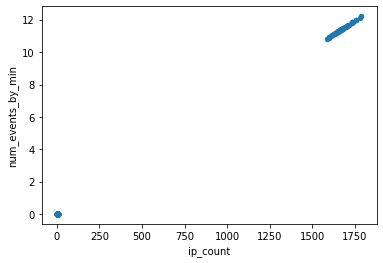

In [148]:
users.plot(kind='scatter', x='ip_count', y='num_events_by_min')

uids_pattern_1 = set(users[(users['num_events_by_min'] > 8) ].uid)
ips_pattern_1 = set([ip for l in users[users['uid'].isin(uids_pattern_1)].ips for ip in l])
print(f'Num users in pattern 1 : {len(uids_pattern_1)}')
print(f'Num ips in pattern 1 : {len(ips_pattern_1)}')
# Pattern 1 : ip_count > 300 == num_event_by_min > 10

In [149]:
df['pattern_1'] = df['uid'].isin(uids_pattern_1)
#df['pattern_1'] = df.apply(lambda x: (x['uid'] in uids_pattern_1) or (x['ip'] in ips_pattern_1), axis=1)
#df['pattern_1'] = df.apply(lambda x: (x['uid'] in uids_pattern_1) and (x['eventType'] == 'click'), axis=1)
print(f"clicks filtered : {df[df['pattern_1'] & (df['eventType'] == 'click')].shape[0]}/{df[df['eventType'] == 'click'].shape[0]}")
print(f"displays filtered : {df[df['pattern_1'] & (df['eventType'] == 'display')].shape[0]}/{df[df['eventType'] == 'display'].shape[0]}")

df_clean = df[~df['pattern_1']].copy()
df_clean.head()

CTR(df_clean)

clicks filtered : 25746/40781
displays filtered : 57785/124360
CTR : 22.5836% | #clicks=15035 ; #displays=66575


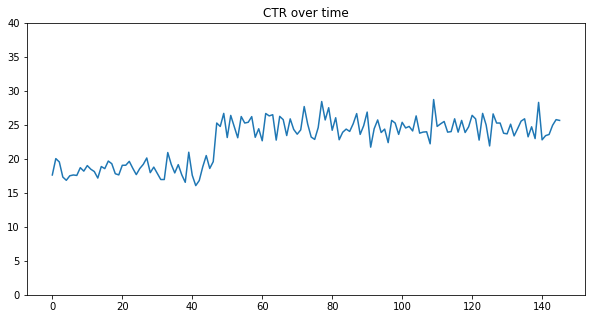

In [150]:
CTR_by_window(df_clean, 1, plot=True)

In [151]:
df_clean['minute'] = df_clean['timestamp'].apply(lambda x: str(x.minute).zfill(2))
df_clean['hour'] = df_clean['timestamp'].apply(lambda x: str(x.hour))
df_clean['hm'] = df_clean.apply(lambda x: x['minute'] + '-' + x['hour'], axis=1)
df_clean

,eventType,uid,timestamp,ip,impressionId,pattern_1,minute,hour,hm
9,click,7534208b-2fa6-4ab0-87a7-aa3a9ca9259413,2021-05-15 13:05:41,238.186.83.58,9a2b0c2c-3226-454b-afd7-3ac5e039cdc6,False,05,13,05-13
13,click,c47b7bd0-954b-450f-98de-e86711956b8e,2021-05-15 13:05:45,210.52.100.97,0717f07a-786e-49fd-b670-9e00a7e718ec,False,05,13,05-13
18,click,e1dcffbd-74b4-404f-ba74-7e15dac51fe110,2021-05-15 13:05:51,238.186.83.58,b1bfe921-4786-4493-9c6c-6c174c31e46a,False,05,13,05-13
19,click,b992a194-7247-4d94-acc4-fac91c93a5d013,2021-05-15 13:05:51,238.186.83.58,5edef539-f2dd-4d9c-97d7-ca8f56517ec3,False,05,13,05-13
20,click,3f014b81-bb7b-4434-93b0-e99c73516a3417,2021-05-15 13:05:51,238.186.83.58,e85b142c-d228-4c4a-b0ee-3d8d44f0ba93,False,05,13,05-13
...,...,...,...,...,...,...,...,...,...
165128,display,12bc78be-0a7c-4e65-a32c-2d6f3477bb5b,2021-05-15 15:32:01,239.118.226.73,89f568e4-201c-4cc9-80d6-bc666ba066d9,False,32,15,32-15
165131,display,a0f8d666-59b2-4e75-9579-cbbaa05637ce,2021-05-15 15:32:01,58.66.16.214,b320cb9f-6b28-4938-b68e-595e19e5c796,False,32,15,32-15
165133,display,008f84a4-2ffa-476f-b158-24f29000bdcf,2021-05-15 15:32:01,21.12.0.8,6429a708-68da-41f1-9772-afcf4f871206,False,32,15,32-15
165136,display,a971702c-54d6-4d57-a539-038eaa95eebb,2021-05-15 15:32:01,253.26.195.62,ee1c3e25-e10f-4dba-a6d9-1aceebc30d91,False,32,15,32-15


In [152]:
df_clean.ip.value_counts()

238.186.83.58     17580
124.164.4.64         19
250.94.254.83        18
80.225.61.234        18
101.14.190.213       18
                  ...  
200.79.178.180        1
99.147.22.17          1
140.142.59.205        1
117.130.87.53         1
77.144.9.247          1
Name: ip, Length: 9976, dtype: int64

In [153]:
tmp = df_clean[df_clean['ip'] !=  '238.186.83.58'].copy()

In [154]:
CTR(tmp)

CTR : 10.8073% | #clicks=6245 ; #displays=57785


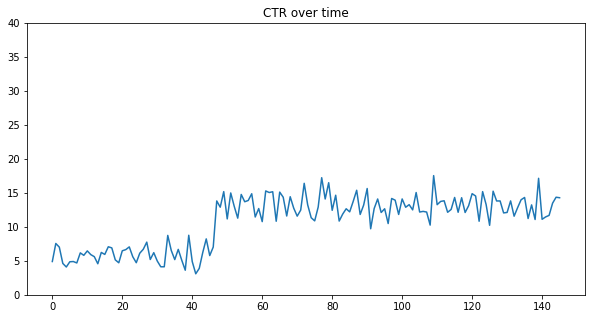

In [155]:
CTR_by_window(tmp, window_size=1)

In [156]:
ips = tmp.groupby('ip').agg({'eventType': list, 'timestamp': list, 'uid': list}).reset_index()
ips

,ip,eventType,timestamp,uid
0,0.106.86.150,"[display, display, click, display, display, di...","[2021-05-15 13:11:51, 2021-05-15 13:30:18, 202...","[bda6f3dc-81a6-4cf1-a6cf-6910de57db55, d369533..."
1,0.108.134.79,"[display, display, display, display, display, ...","[2021-05-15 13:06:18, 2021-05-15 14:12:21, 202...","[afb82102-c830-4dc0-9a6d-5782b28be81e, 6296637..."
2,0.121.162.242,"[display, display, display, display, display, ...","[2021-05-15 13:18:57, 2021-05-15 13:20:29, 202...","[928a9d82-a5f1-4208-8376-45cc242923ff, d6dd0c8..."
3,0.125.58.141,"[display, display, display, display, display]","[2021-05-15 13:34:09, 2021-05-15 14:42:11, 202...","[5f362c99-ed40-4ce4-9287-1794b26b050d, 93efc66..."
4,0.128.213.125,"[display, display, display, display, display, ...","[2021-05-15 13:22:14, 2021-05-15 13:42:38, 202...","[2928a4d6-c7fa-4f64-9577-3664cae3cc2c, 5341d10..."
...,...,...,...,...
9970,99.84.14.188,"[display, display, display, display, display, ...","[2021-05-15 13:50:38, 2021-05-15 14:01:35, 202...","[fb6a13ed-e423-4d56-a774-7c77618736d0, 354dcc3..."
9971,99.85.134.167,"[display, display, display, display, display]","[2021-05-15 13:38:56, 2021-05-15 14:10:24, 202...","[3554b7c1-68d9-49f2-a740-781d3ca1e314, 3a4c6c2..."
9972,99.85.214.192,"[display, display, display, display, display, ...","[2021-05-15 13:57:52, 2021-05-15 14:21:43, 202...","[900e0256-8a0b-49ce-adb4-9e2bdcbe1448, 0a20a94..."
9973,99.87.65.211,"[display, display, display, display, display]","[2021-05-15 13:24:09, 2021-05-15 13:32:00, 202...","[bed70a49-0d17-45ab-abf6-63841bd79e39, 94f7de8..."


In [157]:
ips['num_events'] = ips.eventType.apply(lambda x: len(x))
ips['diff_time'] = ips.timestamp.apply(lambda x: max(x) - min(x))
ips['diff_sec'] = ips.diff_time.apply(lambda x: x.total_seconds())
ips

,ip,eventType,timestamp,uid,num_events,diff_time,diff_sec
0,0.106.86.150,"[display, display, click, display, display, di...","[2021-05-15 13:11:51, 2021-05-15 13:30:18, 202...","[bda6f3dc-81a6-4cf1-a6cf-6910de57db55, d369533...",11,0 days 01:45:21,6321.0
1,0.108.134.79,"[display, display, display, display, display, ...","[2021-05-15 13:06:18, 2021-05-15 14:12:21, 202...","[afb82102-c830-4dc0-9a6d-5782b28be81e, 6296637...",6,0 days 02:19:36,8376.0
2,0.121.162.242,"[display, display, display, display, display, ...","[2021-05-15 13:18:57, 2021-05-15 13:20:29, 202...","[928a9d82-a5f1-4208-8376-45cc242923ff, d6dd0c8...",7,0 days 01:36:13,5773.0
3,0.125.58.141,"[display, display, display, display, display]","[2021-05-15 13:34:09, 2021-05-15 14:42:11, 202...","[5f362c99-ed40-4ce4-9287-1794b26b050d, 93efc66...",5,0 days 01:47:58,6478.0
4,0.128.213.125,"[display, display, display, display, display, ...","[2021-05-15 13:22:14, 2021-05-15 13:42:38, 202...","[2928a4d6-c7fa-4f64-9577-3664cae3cc2c, 5341d10...",8,0 days 01:47:13,6433.0
...,...,...,...,...,...,...,...
9970,99.84.14.188,"[display, display, display, display, display, ...","[2021-05-15 13:50:38, 2021-05-15 14:01:35, 202...","[fb6a13ed-e423-4d56-a774-7c77618736d0, 354dcc3...",7,0 days 01:41:16,6076.0
9971,99.85.134.167,"[display, display, display, display, display]","[2021-05-15 13:38:56, 2021-05-15 14:10:24, 202...","[3554b7c1-68d9-49f2-a740-781d3ca1e314, 3a4c6c2...",5,0 days 01:37:27,5847.0
9972,99.85.214.192,"[display, display, display, display, display, ...","[2021-05-15 13:57:52, 2021-05-15 14:21:43, 202...","[900e0256-8a0b-49ce-adb4-9e2bdcbe1448, 0a20a94...",6,0 days 01:25:41,5141.0
9973,99.87.65.211,"[display, display, display, display, display]","[2021-05-15 13:24:09, 2021-05-15 13:32:00, 202...","[bed70a49-0d17-45ab-abf6-63841bd79e39, 94f7de8...",5,0 days 02:07:51,7671.0


In [158]:
uids = tmp.groupby('uid').agg({'eventType':list, 'timestamp':list}).rename({'eventType':'events', 'timestamp':'timestamps'}, axis=1)
uids['num_events'] = uids.events.apply(lambda x: len(x))
uids.head()

,events,timestamps,num_events
uid,,,
00057b36-3574-4d7e-b0d0-1703ae4e3fe1,[display],[2021-05-15 14:37:34],1
000a92c5-643a-4e5a-8f4e-bc8f4be28156,[display],[2021-05-15 14:49:38],1
000ac623-ef3b-4c3c-9d12-01367b8f0b3b,[display],[2021-05-15 15:15:01],1
000af57e-5a84-48fa-95a8-ba5e5ba68867,[display],[2021-05-15 14:42:49],1
000bbdc5-f95b-4504-8b93-5d5a124e5716,[display],[2021-05-15 14:38:06],1


In [159]:
def min_diff_time(timestamps):
    if len(timestamps) == 1 :
        return 0.
    min_delta = float('inf')
    for i in range(1, len(timestamps)):
        delta = (timestamps[i] - timestamps[i-1]).total_seconds()
        if delta < min_delta:
            min_delta = delta
    return min_delta


uids['time_diff_sec'] = uids.apply(lambda x: (max(x['timestamps']) - min(x['timestamps'])).total_seconds(), axis=1)
uids['min_time_diff_sec'] = uids.apply(lambda x: min_diff_time(x['timestamps']), axis=1)

In [160]:
uids[(uids.min_time_diff_sec < 10) & (uids.num_events >= 2)]

,events,timestamps,num_events,time_diff_sec,min_time_diff_sec
uid,,,,,
0fdfed27-dcea-4c84-8951-6dad4020e027,"[display, display]","[2021-05-15 14:50:19, 2021-05-15 14:50:26]",2,7.0,7.0
113ac7f4-5222-4c65-b3f5-1ac94fff6d3a,"[display, click]","[2021-05-15 14:03:52, 2021-05-15 14:03:58]",2,6.0,6.0
2e93bb17-a722-41f6-870a-effd10fb742e,"[display, click, display]","[2021-05-15 14:50:20, 2021-05-15 14:53:35, 202...",3,201.0,6.0
4190f61c-251f-4cf9-abad-d6e8ce4d99d5,"[display, display, click]","[2021-05-15 13:38:49, 2021-05-15 13:38:58, 202...",3,6634.0,9.0
4beb5675-bcc5-454c-b5ac-007b03d9815a,"[display, click, display]","[2021-05-15 13:18:48, 2021-05-15 15:25:24, 202...",3,7600.0,4.0
508a864c-c44c-45cd-9c56-186e6e041ccf,"[display, click]","[2021-05-15 14:39:47, 2021-05-15 14:39:53]",2,6.0,6.0
5462f958-ee8a-43f6-809e-5f7d05ba860e,"[display, click]","[2021-05-15 13:18:49, 2021-05-15 13:18:55]",2,6.0,6.0
67d34069-1073-4559-8091-ce09c5b6e73e,"[display, click]","[2021-05-15 13:23:08, 2021-05-15 13:23:10]",2,2.0,2.0
7fee8ac4-93a8-452f-97c8-7fed559c68a8,"[display, click]","[2021-05-15 14:14:29, 2021-05-15 14:14:38]",2,9.0,9.0


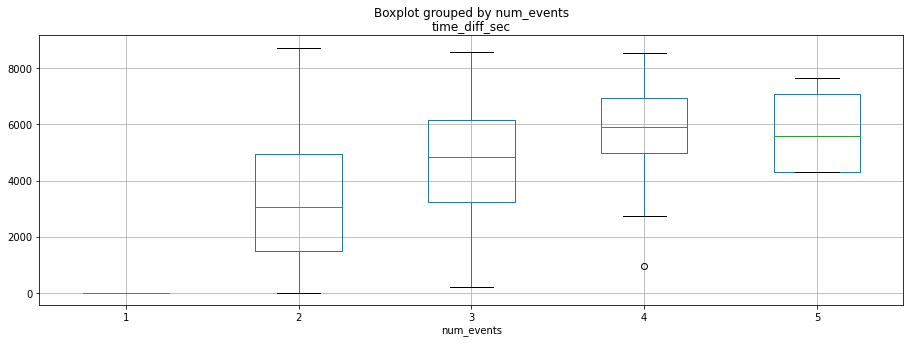

In [161]:
uids.boxplot(column='time_diff_sec', by='num_events', figsize=(15, 5));

In [162]:
uids_pattern_3 = set(uids[(uids.num_events >= 2) & (uids.time_diff_sec <= 0.5)].reset_index().uid)
uids_pattern_3

{'fe2bc12c-f715-4f11-a5b3-9abf6aaa9934'}

In [163]:
out = tmp[~tmp['uid'].isin(uids_pattern_3)].copy()
CTR(out.tail(30000))

CTR : 13.0497% | #clicks=3463 ; #displays=26537


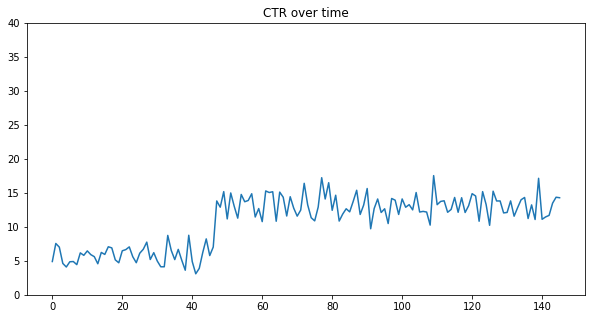

In [165]:
CTR_by_window(out, window_size=1)